<a href="https://colab.research.google.com/github/yagumana/HelloGit/blob/master/vae_fashionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42
# from .types_ import *

In [66]:
# pip install types

In [67]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [68]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [69]:
training_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [120]:
batch_size = 64
train_data, val_data = torch.utils.data.random_split(training_data,[50000, 10000])

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [71]:
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [72]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [79]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [124]:
class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=20, hidden_dims= [15,45,90,180]):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [15, 45, 90, 180]

        # Build Encoder
        for h_dim in hidden_dims:
            # print(1)
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i+1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=1,
                                      kernel_size= 3, padding=0),
                            nn.Tanh())
        
    def encode(self, input):
        result = self.encoder(input)
        # print(result.shape)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return[mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 180, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        # recons_loss = F.mse_loss(recons, input)

        input = input.view(-1,784)
        recons = recons.view(-1,784)
        recons_loss = torch.mean(torch.sum(input*torch_log(recons) + (1 - input) * torch_log(1-recons), dim=1))


        input = input.view(-1,1,28,28)
        recons = recons.view(-1,1,28,28)
        kld_loss = torch.mean(0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = -(recons_loss + kld_weight * kld_loss)
        return [loss, recons_loss, kld_loss]

    def generate(self, x):
        return self.forward(x)[0]

In [132]:
in_channels = 1
latent_dim = 30
n_epochs = 15
lr = 0.0005
model = VAE(in_channels=in_channels,latent_dim = latent_dim).to(device)

In [133]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [134]:
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x,t in train_dataloader:
        x = x.to(device)

        model.zero_grad()

        recons, input, mu, log_var = model.forward(x)
        # print(recons.shape)
        # print(input.shape)
        loss, reconstruction_loss, KL_loss = model.loss_function(recons, input, mu, log_var,M_N=1)

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x,t in val_dataloader:

        x = x.to(device)
        
        recons, input, mu, log_var = model.forward(x)

        loss, reconstruction_loss, KL_loss = model.loss_function(recons,input,mu,log_var,M_N=1)

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %(epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH:1, Train Lower Bound:444.048431, (-20.903687, -423.144745), Valid Lower Bound:312.402008
EPOCH:2, Train Lower Bound:299.249695, (-38.823132, -260.426575), Valid Lower Bound:255.918243
EPOCH:3, Train Lower Bound:242.524780, (-36.756012, -205.768768), Valid Lower Bound:196.493652
EPOCH:4, Train Lower Bound:391.378479, (-89.322647, -302.055817), Valid Lower Bound:300.024200
EPOCH:5, Train Lower Bound:289.901367, (-58.908176, -230.993164), Valid Lower Bound:229.713730
EPOCH:6, Train Lower Bound:215.593597, (-31.629930, -183.963669), Valid Lower Bound:176.218201
EPOCH:7, Train Lower Bound:223.337997, (-43.364380, -179.973633), Valid Lower Bound:183.320755
EPOCH:8, Train Lower Bound:195.097488, (-33.882347, -161.215149), Valid Lower Bound:216.199295
EPOCH:9, Train Lower Bound:197.648331, (-36.425903, -161.222427), Valid Lower Bound:1883.856323
EPOCH:10, Train Lower Bound:569.819458, (-158.087524, -411.731903), Valid Lower Bound:602.185120
EPOCH:11, Train Lower Bound:468.904816, (-131.6

KeyboardInterrupt: ignored

In [77]:
x,t = val_data[0]
x = x.to(device)
x.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

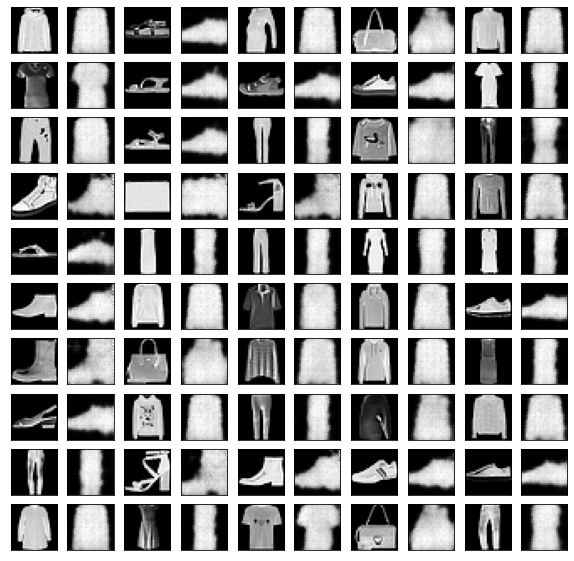

In [128]:
fig = plt.figure(figsize=(10,10))
model.eval()
for i in range(50):
    x, t = val_data[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    recons = model.forward(x)[0]
    x = x.view(-1,28,28).permute(1, 2, 0).squeeze().numpy()
    recons = recons.view(-1,28,28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i*2+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')
    ax = fig.add_subplot(10, 10, i*2+2, xticks=[], yticks=[])
    ax.imshow(recons, 'gray')